In [27]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
# In terminal: pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

PCOS = pd.read_csv("PCOS.csv")

# Data Cleaning

PCOS (Y/N): Age (C), Weight(C), pulse rate (C), RR (C), BMI (C), Years of marriage (C), Pregnant (B), Fast Food (B), Regular Exercise (B), No. of abortions (C), cycle length (c), waist/hip ratio (C), hair growth (B), pimples (B), blood group (cat)


In [28]:
data = PCOS.loc[:, ["PCOS (Y/N)", "Age (yrs)", "Weight (Kg)", "Height(Cm)", "Pulse rate(bpm)", "RR (breaths/min)", "Marraige Status (Yrs)", 'Fast food (Y/N)', "Pregnant(Y/N)", "No. of aborptions", "Hip(inch)", "Waist(inch)", "Reg.Exercise(Y/N)", "Cycle(R/I)", "hair growth(Y/N)", "Pimples(Y/N)", "Blood Group"]]

# Organizing data
data["H/W Ratio"] = data["Hip(inch)"]/data["Waist(inch)"]
data["Height(M)"] = data["Height(Cm)"]/100
data["BMI"] = data["Weight (Kg)"]/np.square(data["Height(M)"])
data = data.reindex(columns=["PCOS (Y/N)", "Age (yrs)", "Weight (Kg)", "Height(Cm)", "BMI", "Pulse rate(bpm)", "RR (breaths/min)", "Marraige Status (Yrs)", 'Fast food (Y/N)', "Pregnant(Y/N)", "No. of aborptions", "H/W Ratio", "Reg.Exercise(Y/N)", "Cycle(R/I)", "hair growth(Y/N)", "Pimples(Y/N)", "Blood Group"])

In [29]:
# Adding in missing values with mean of other values
missing_cols = data.columns[data.isna().any()].tolist()
for x in missing_cols:
    data[x] = data[x].fillna(data[x].mean())

In [30]:
data.head()

,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Pulse rate(bpm),RR (breaths/min),Marraige Status (Yrs),Fast food (Y/N),Pregnant(Y/N),No. of aborptions,H/W Ratio,Reg.Exercise(Y/N),Cycle(R/I),hair growth(Y/N),Pimples(Y/N),Blood Group
0,0,28,44.6,152.0,19.304017,78,22,7.0,1.0,0,0,1.200000,0,2,0,0,15
1,0,36,65.0,161.5,24.921163,74,20,11.0,0.0,1,0,1.187500,0,2,0,0,15
2,1,33,68.8,165.0,25.270891,72,18,10.0,1.0,1,0,1.111111,0,2,0,1,11
3,0,37,65.0,148.0,29.674945,72,20,4.0,0.0,0,0,1.166667,0,2,0,0,13
4,0,25,52.0,161.0,20.060954,72,18,1.0,0.0,1,0,1.233333,0,2,0,0,11


# Use SMOTE to generate more values

In [31]:
data["PCOS (Y/N)"].value_counts()

0    364
1    177
Name: PCOS (Y/N), dtype: int64

In [32]:
X=data.iloc[:,1:]
X.isnull().sum()
y=data.iloc[:,0]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 20)

In [33]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 142
Before OverSampling, counts of label '0': 290 

After OverSampling, the shape of train_X: (580, 16)
After OverSampling, the shape of train_y: (580,) 

After OverSampling, counts of label '1': 290
After OverSampling, counts of label '0': 290


In [34]:
y = pd.DataFrame(y_train_res, columns=["PCOS (Y/N)"])

In [37]:
data = pd.concat([X_train_res, y], axis = 1) 
data = data.reindex(columns=["PCOS (Y/N)", "Age (yrs)", "Weight (Kg)", "Height(Cm)", "BMI", "Pulse rate(bpm)", "RR (breaths/min)", "Marraige Status (Yrs)", 'Fast food (Y/N)', "Pregnant(Y/N)", "No. of aborptions", "H/W Ratio", "Reg.Exercise(Y/N)", "Cycle(R/I)", "hair growth(Y/N)", "Pimples(Y/N)", "Blood Group"])
data = data.rename(columns={"PCOS (Y/N)":"PCOS", "Age (yrs)":"age", "Weight (Kg)": "weight", "Height(Cm)": "height", "Pulse rate(bpm)": "pulse_rate", "RR (breaths/min)": "RR", "Marraige Status (Yrs)": "marriage_years", 'Fast food (Y/N)': "fast_food", "Pregnant(Y/N)": "pregnant", "No. of aborptions": "number_abortions", "H/W Ratio": "h/w_ratio", "Reg.Exercise(Y/N)": "regular_excercise", "Cycle(R/I)": "cycle", "hair growth(Y/N)": "hair_growth", "Pimples(Y/N)": "pimples"})
data.head()


,PCOS,age,weight,height,BMI,pulse_rate,RR,marriage_years,fast_food,pregnant,number_abortions,h/w_ratio,regular_excercise,cycle,hair_growth,pimples,Blood Group
0,0,33,58.5,159.000,23.139907,72,20,13.0,0.0,1,2,1.157895,0,2,0,0,13
1,1,27,50.0,168.000,17.715420,72,18,7.0,0.0,0,0,1.040000,0,4,1,1,13
2,0,38,70.0,164.592,25.839291,72,18,8.0,0.0,0,0,1.095238,0,2,1,1,16
3,0,34,60.0,156.000,24.654832,74,20,7.0,0.0,0,0,1.218750,0,2,0,0,14
4,1,31,50.0,158.000,20.028842,74,20,11.0,1.0,0,0,1.200000,1,2,0,1,11


In [39]:
data.shape

(580, 18)

### Changing Blood Group into categories

In [40]:
blood_group_map = {11: "A+", 12: "A-", 13: "B+", 14: "B-", 15: "O+", 16: "O-", 17: "AB+", 18: "AB-"}

data.loc[:, "blood_group_cat"] = data.loc[:, "Blood Group"].map(blood_group_map)
data.head()

,PCOS,age,weight,height,BMI,pulse_rate,RR,marriage_years,fast_food,pregnant,number_abortions,h/w_ratio,regular_excercise,cycle,hair_growth,pimples,Blood Group,blood_group_cat
0,0,33,58.5,159.000,23.139907,72,20,13.0,0.0,1,2,1.157895,0,2,0,0,13,B+
1,1,27,50.0,168.000,17.715420,72,18,7.0,0.0,0,0,1.040000,0,4,1,1,13,B+
2,0,38,70.0,164.592,25.839291,72,18,8.0,0.0,0,0,1.095238,0,2,1,1,16,O-
3,0,34,60.0,156.000,24.654832,74,20,7.0,0.0,0,0,1.218750,0,2,0,0,14,B-
4,1,31,50.0,158.000,20.028842,74,20,11.0,1.0,0,0,1.200000,1,2,0,1,11,A+


# EDA

### Testing if age needs transformation

<AxesSubplot:xlabel='PCOS', ylabel='age'>

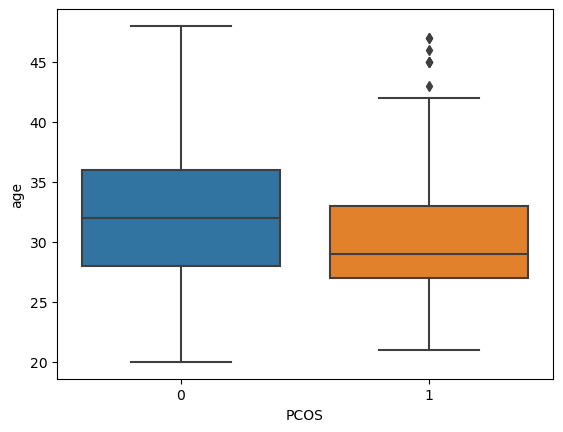

In [45]:
sns.boxplot(x = 'PCOS', y = 'age', data = data)

In [51]:
#Binning Age
binned_age = pd.qcut(data['age'], 10, retbins=True)
data['age_binned'] = binned_age[0]

In [52]:
#Finding percentage of people having diabetes in each Age bin
age_data = data.groupby('age_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
age_data

,age_binned,PCOS_percent,nobs
0,"(19.999, 25.0]",0.662500,80
1,"(25.0, 27.0]",0.507042,71
2,"(27.0, 28.0]",0.630435,46
3,"(28.0, 29.0]",0.697674,43
4,"(29.0, 31.0]",0.568182,88
5,"(31.0, 32.0]",0.363636,44
6,"(32.0, 34.0]",0.462963,54
7,"(34.0, 35.0]",0.410256,39
8,"(35.0, 38.0]",0.328358,67
9,"(38.0, 48.0]",0.270833,48


Text(0.5, 0, 'Age_bin')

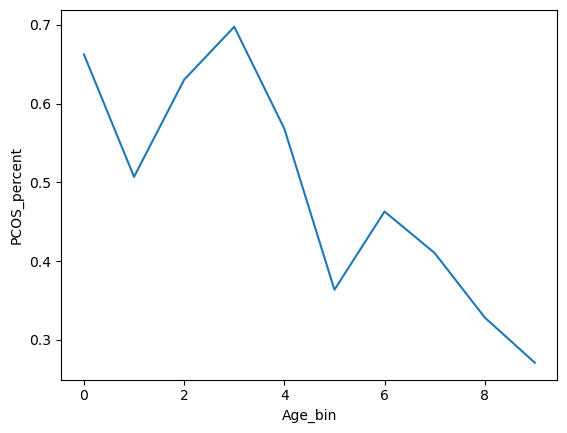

In [53]:
sns.lineplot(x = age_data.index, y = age_data['PCOS_percent'])
plt.xlabel('Age_bin')

We observe that the probability of people having PCOS does not keep decreasing monotonically with age. However, it is still relatively linear, so we do not need to perform a transformation.

### Testing if weight needs transformation

<AxesSubplot:xlabel='PCOS', ylabel='weight'>

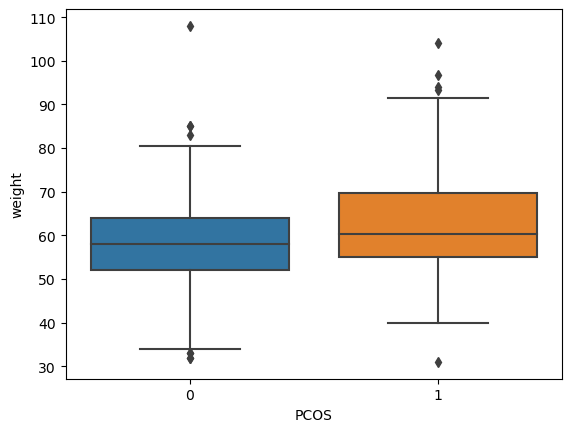

In [54]:
sns.boxplot(x = 'PCOS', y = 'weight', data = data)

In [56]:
#Binning weight
binned_weight = pd.qcut(data['weight'], 6, retbins=True)
data['weight_binned'] = binned_weight[0]

In [57]:
#Finding percentage of people having diabetes in each Age bin
weight_data = data.groupby('weight_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
weight_data

,weight_binned,PCOS_percent,nobs
0,"(30.999, 50.562]",0.319588,97
1,"(50.562, 55.0]",0.471154,104
2,"(55.0, 59.951]",0.573034,89
3,"(59.951, 64.0]",0.415094,106
4,"(64.0, 70.587]",0.563218,87
5,"(70.587, 108.0]",0.680412,97


Text(0.5, 0, 'Weight_bin')

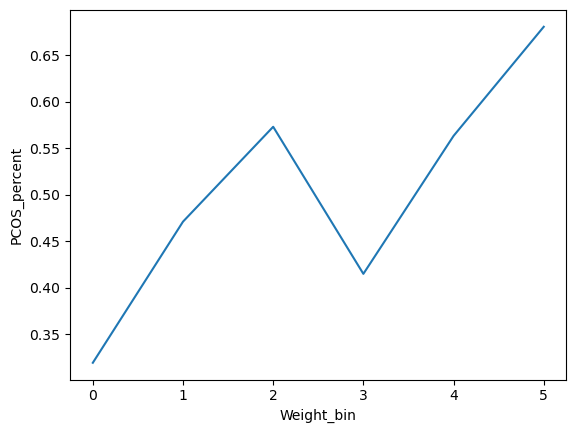

In [59]:
sns.lineplot(x = weight_data.index, y = weight_data['PCOS_percent'])
plt.xlabel('Weight_bin')

# Logistic Regression

In [42]:
model1 = smf.logit("PCOS ~ weight", data = data).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.669478
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  580
Model:                          Logit   Df Residuals:                      578
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:                 0.03415
Time:                        14:43:01   Log-Likelihood:                -388.30
converged:                       True   LL-Null:                       -402.03
Covariance Type:            nonrobust   LLR p-value:                 1.607e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4610      0.497     -4.951      0.000      -3.435      -1.487
weight         0.0409      0.008      5.011      0.000       0.025       0.057
==============================================================================
"""

Classification accuracy = 56.0%


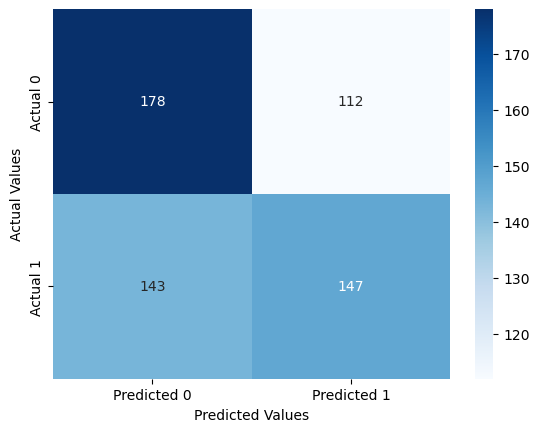

In [43]:
#Function to compute confusion matrix and prediction accuracy on training data
def confusion_matrix_train(model,cutoff=0.5):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    
confusion_matrix_train(model1)

In [ ]:
#